### Data Pre-Processing

This notebook will deal with the data preprocessing for CounselChat followed by little visualization related to data statistics:

1. Remove any non-unicode characters from data e.g., non-breakable spaces, smileys, etc.
2. Remove all the rows having empty questions/answers
3. Get the distribution of the answers length in the dataset
4. Map the answers with the votes to see if long answers are getting more number of votes
5. Save the filtered dataset (question/answer pairs) to be used for further inference and/or evaluation

In [2]:
from datasets import load_dataset
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

/data/mn27889/miniconda3/envs/mental-health/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'matplotlib'

Setting the seeds

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Get the CounselChat Dataset

In [3]:
dataset_name = "nbertagnolli/counsel-chat"
dataset = load_dataset(dataset_name, split="all")

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
dataset_df = dataset.to_pandas()
dataset_df.head()

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views
0,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Jennifer MolinariHypnotherapist & Licensed Cou...,https://counselchat.com/therapists/jennifer-mo...,It is very common for people to have multiple ...,3,1971
1,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Jason Lynch, MS, LMHC, LCAC, ADSIndividual & C...",https://counselchat.com/therapists/jason-lynch...,"I've never heard of someone having ""too many i...",2,386
2,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Shakeeta TorresFaith Based Mental Health Couns...,https://counselchat.com/therapists/shakeeta-to...,Absolutely not. I strongly recommending worki...,2,3071
3,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Noorayne ChevalierMA, RP, CCC, CCAC, LLP (Mich...",https://counselchat.com/therapists/noorayne-ch...,Let me start by saying there are never too man...,2,2643
4,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Toni Teixeira, LCSWYour road to healing begins...",https://counselchat.com/therapists/toni-teixei...,I just want to acknowledge you for the courage...,1,256


Form the complete question as concatenation of the `questionText` + `questionTitle`

In [5]:
dataset_df['question'] = dataset_df['questionText'] + " " + dataset_df['questionTitle']
dataset_df

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,question
0,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Jennifer MolinariHypnotherapist & Licensed Cou...,https://counselchat.com/therapists/jennifer-mo...,It is very common for people to have multiple ...,3,1971,I have so many issues to address. I have a his...
1,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Jason Lynch, MS, LMHC, LCAC, ADSIndividual & C...",https://counselchat.com/therapists/jason-lynch...,"I've never heard of someone having ""too many i...",2,386,I have so many issues to address. I have a his...
2,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Shakeeta TorresFaith Based Mental Health Couns...,https://counselchat.com/therapists/shakeeta-to...,Absolutely not. I strongly recommending worki...,2,3071,I have so many issues to address. I have a his...
3,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Noorayne ChevalierMA, RP, CCC, CCAC, LLP (Mich...",https://counselchat.com/therapists/noorayne-ch...,Let me start by saying there are never too man...,2,2643,I have so many issues to address. I have a his...
4,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Toni Teixeira, LCSWYour road to healing begins...",https://counselchat.com/therapists/toni-teixei...,I just want to acknowledge you for the courage...,1,256,I have so many issues to address. I have a his...
...,...,...,...,...,...,...,...,...,...,...,...
2770,939,Are some clients more difficult than others?,What are some difficulties that a counselor ca...,https://counselchat.com/questions/are-some-cli...,counseling-fundamentals,Audrey ONealBi-lingual Psychotherapist and Hea...,https://counselchat.com/therapists/audrey-oneal-3,Although many clients have the capacity to be ...,0,47,What are some difficulties that a counselor ca...
2771,939,Are some clients more difficult than others?,What are some difficulties that a counselor ca...,https://counselchat.com/questions/are-some-cli...,counseling-fundamentals,"Kaileen McMickle, MS, LPCLicensed Professional...",https://counselchat.com/therapists/kaileen-mcm...,"I usually don't label a client as ""difficult"" ...",0,22,What are some difficulties that a counselor ca...
2772,939,Are some clients more difficult than others?,What are some difficulties that a counselor ca...,https://counselchat.com/questions/are-some-cli...,counseling-fundamentals,"Dr. Timothy Paul'man'; Online - ""Natural Healt...",https://counselchat.com/therapists/dr-timothy-...,"Dang right! :)Heh heh, and correct me if I'm ...",0,23,What are some difficulties that a counselor ca...
2773,939,Are some clients more difficult than others?,What are some difficulties that a counselor ca...,https://counselchat.com/questions/are-some-cli...,counseling-fundamentals,"David KleinHumanistic, LGBT-Affirmative Psycho...",https://counselchat.com/therapists/david-klein,"Yes, just like some relationships outside of o...",0,41,What are some difficulties that a counselor ca...


Getting the relevant columns and dropping the rest

In [6]:
dataset_df = dataset_df[['topic', 'questionID', 'question', 'answerText', 'upvotes']]
dataset_df.head()

,topic,questionID,question,answerText,upvotes
0,depression,0,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,3
1,depression,0,I have so many issues to address. I have a his...,"I've never heard of someone having ""too many i...",2
2,depression,0,I have so many issues to address. I have a his...,Absolutely not. I strongly recommending worki...,2
3,depression,0,I have so many issues to address. I have a his...,Let me start by saying there are never too man...,2
4,depression,0,I have so many issues to address. I have a his...,I just want to acknowledge you for the courage...,1


In [7]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   topic       2775 non-null   object
 1   questionID  2775 non-null   int64 
 2   question    2636 non-null   object
 3   answerText  2749 non-null   object
 4   upvotes     2775 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 108.5+ KB


Dropping all the rows where question/answer is `NaN`

In [8]:
dataset_df = dataset_df.dropna().reset_index(drop=True)
dataset_df

,topic,questionID,question,answerText,upvotes
0,depression,0,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,3
1,depression,0,I have so many issues to address. I have a his...,"I've never heard of someone having ""too many i...",2
2,depression,0,I have so many issues to address. I have a his...,Absolutely not. I strongly recommending worki...,2
3,depression,0,I have so many issues to address. I have a his...,Let me start by saying there are never too man...,2
4,depression,0,I have so many issues to address. I have a his...,I just want to acknowledge you for the courage...,1
...,...,...,...,...,...
2607,counseling-fundamentals,939,What are some difficulties that a counselor ca...,Although many clients have the capacity to be ...,0
2608,counseling-fundamentals,939,What are some difficulties that a counselor ca...,"I usually don't label a client as ""difficult"" ...",0
2609,counseling-fundamentals,939,What are some difficulties that a counselor ca...,"Dang right! :)Heh heh, and correct me if I'm ...",0
2610,counseling-fundamentals,939,What are some difficulties that a counselor ca...,"Yes, just like some relationships outside of o...",0


### Question/Answer Text Cleaning

Cleaning the question/answer text from all the non-unicode characters

In [9]:
def remove_emojis(df_bios):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', df_bios)

In [10]:
dataset_df['question'] = dataset_df['question'].apply(remove_emojis)
dataset_df['question'] = dataset_df['question'].apply(lambda x: x.replace('\xa0', ' ').replace(u"\u2019","'").replace(u"\u00e9","ee").replace("\n",' ').replace("  ", " "))

In [11]:
dataset_df['answerText'] = dataset_df['answerText'].apply(remove_emojis)
dataset_df['answerText'] = dataset_df['answerText'].apply(lambda x: x.replace('\xa0', ' ').replace(u"\u2019","'").replace(u"\u00e9","ee").replace("\n",' ').replace("  ", " "))

### Statistics of Answer Length

In [12]:
dataset_df['answer_length'] = dataset_df['answerText'].apply(lambda x: len(x.split()))
dataset_df

,topic,questionID,question,answerText,upvotes,answer_length
0,depression,0,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,3,172
1,depression,0,I have so many issues to address. I have a his...,"I've never heard of someone having ""too many i...",2,107
2,depression,0,I have so many issues to address. I have a his...,Absolutely not. I strongly recommending workin...,2,42
3,depression,0,I have so many issues to address. I have a his...,Let me start by saying there are never too man...,2,272
4,depression,0,I have so many issues to address. I have a his...,I just want to acknowledge you for the courage...,1,200
...,...,...,...,...,...,...
2607,counseling-fundamentals,939,What are some difficulties that a counselor ca...,Although many clients have the capacity to be ...,0,171
2608,counseling-fundamentals,939,What are some difficulties that a counselor ca...,"I usually don't label a client as ""difficult"" ...",0,253
2609,counseling-fundamentals,939,What are some difficulties that a counselor ca...,"Dang right! :)Heh heh, and correct me if I'm w...",0,53
2610,counseling-fundamentals,939,What are some difficulties that a counselor ca...,"Yes, just like some relationships outside of o...",0,205


In [13]:
dataset_df['answer_length'].describe()

count    2612.000000
mean      169.301302
std       119.065887
min         1.000000
25%        88.000000
50%       137.000000
75%       214.000000
max       939.000000
Name: answer_length, dtype: float64

Let's firstly draw the histogram of answer lengths

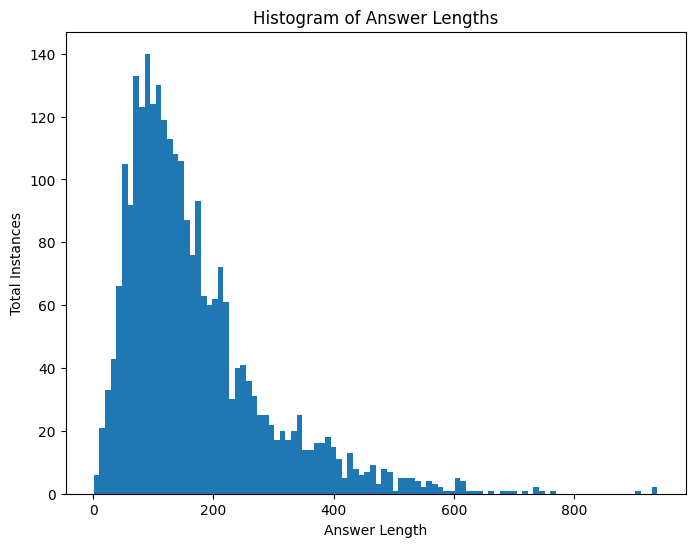

In [14]:
plt.figure(figsize=(8,6))
plt.hist(dataset_df['answer_length'].to_list(), bins=100)
plt.xlabel('Answer Length')
plt.ylabel('Total Instances')
plt.title('Histogram of Answer Lengths')
plt.show()

Let's draw the average length for each number of votes

In [ ]:
avg_length_by_upvotes = dataset_df[['upvotes', 'answer_length']].groupby('upvotes')['answer_length'].agg(['mean', 'count'])
avg_length_by_upvotes

NameError: name 'dataset_df' is not defined

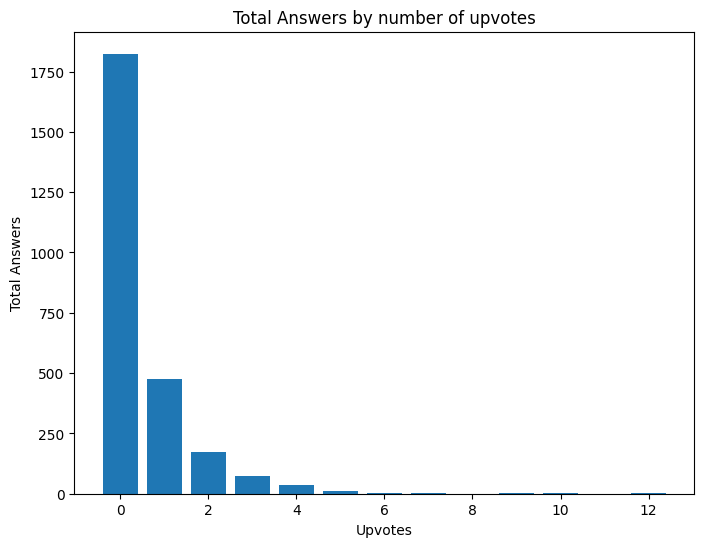

In [16]:
plt.figure(figsize=(8,6))
plt.bar(avg_length_by_upvotes.index.to_list(), avg_length_by_upvotes['count'].tolist())
plt.xlabel('Upvotes')
plt.ylabel('Total Answers')
plt.title('Total Answers by number of upvotes')
plt.show()

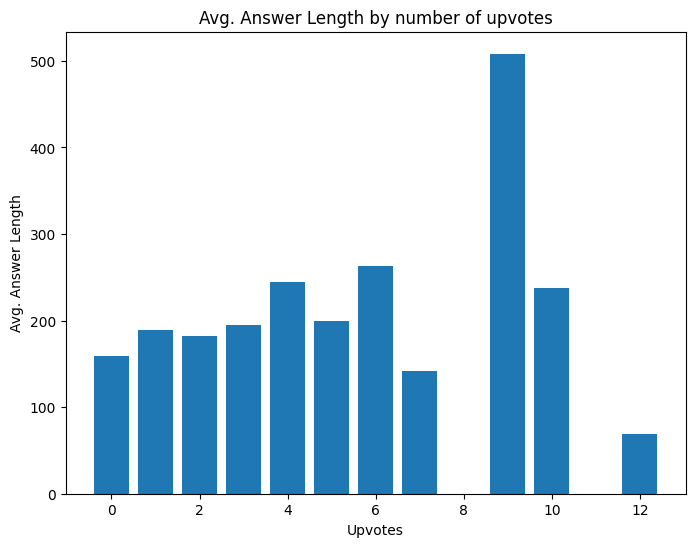

In [17]:
plt.figure(figsize=(8,6))
plt.bar(avg_length_by_upvotes.index.to_list(), avg_length_by_upvotes['mean'].tolist())
plt.xlabel('Upvotes')
plt.ylabel('Avg. Answer Length')
plt.title('Avg. Answer Length by number of upvotes')
plt.show()

We need to calculate the statistics by looking at the questions

During LLM evaluation, we need to see whether higher voted answer is actually being marked as higher quality [Contrastive Learning for Prediction between the two answers of the same question to evaluate if the higher voted answer has the best rating or not.]

### Getting Top Voted answer for each question

In [18]:
dataset_df_top_votes = dataset_df.groupby('questionID').apply(lambda x: x.sort_values('upvotes', ascending=False).iloc[0], include_groups=False).reset_index()
dataset_df_top_votes

,questionID,topic,question,answerText,upvotes,answer_length
0,0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,3,172
1,1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically, ...",2,67
2,2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...,2,62
3,3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...,1,25
4,4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...,3,361
...,...,...,...,...,...,...
858,935,counseling-fundamentals,Does counseling really do anything that can he...,"Yes, Counseling provides an area for people to...",3,57
859,936,counseling-fundamentals,How does a person start the counseling process...,"Hello, There are many ways to approach a couns...",3,163
860,937,counseling-fundamentals,"After first meeting the client, what is the pr...",I think this question can vary based on the in...,0,145
861,938,counseling-fundamentals,What are the basic skills a good counselor nee...,"Some basic skills are empathy, you should feel...",0,65


In [19]:
dataset_df_top_votes = dataset_df_top_votes[['topic', 'question', 'answerText']]
dataset_df_top_votes

,topic,question,answerText
0,depression,I have so many issues to address. I have a his...,It is very common for people to have multiple ...
1,depression,I have been diagnosed with general anxiety and...,"This can be a difficult situation. Typically, ..."
2,depression,My mother is combative with me when I say I do...,Do you live with your mom and have constant in...
3,depression,There are many people willing to lovingly prov...,I truly understand what you are saying. I want...
4,depression,My girlfriend just quit drinking and she becam...,You're probably not going to like my answer.Yo...
...,...,...,...
858,counseling-fundamentals,Does counseling really do anything that can he...,"Yes, Counseling provides an area for people to..."
859,counseling-fundamentals,How does a person start the counseling process...,"Hello, There are many ways to approach a couns..."
860,counseling-fundamentals,"After first meeting the client, what is the pr...",I think this question can vary based on the in...
861,counseling-fundamentals,What are the basic skills a good counselor nee...,"Some basic skills are empathy, you should feel..."


Shuffling the Data to avoid any bias

In [20]:
dataset_df_top_votes = dataset_df_top_votes.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
dataset_df_top_votes

,topic,question,answerText
0,relationships,I am currently suffering from erectile dysfunc...,"Hi, First and foremost, I want to acknowledge ..."
1,family-conflict,For the past week or so me and my boyfriend ha...,Forgetting one's emotions is impossible.Since ...
2,depression,I am in high school and have been facing anxie...,"Hi Helena,I felt a bit sad when I read this. T..."
3,anxiety,I'm concerned about my boyfriend. I suffer fro...,Hello! Thank you for your question. There are ...
4,spirituality,"I'm a Christian teenage girl, and I have lost ...",Having sex with your boyfriend is and was a mi...
...,...,...,...
858,depression,"They don't go away, and I feel like I'm going ...",Since you realize that hearing voices in your ...
859,parenting,My husband's ex-wife married a man who was cha...,If the daughters are old & mature enough to un...
860,counseling-fundamentals,"After first meeting the client, what is the pr...",I think this question can vary based on the in...
861,anger-management,I been having anger problems a lot lately. It ...,With me knowing that a healthy relationship us...


Converting the dataset into train/test pairs for inference and evaluation

In [21]:
top_votes_train, top_votes_test = np.split(dataset_df_top_votes, [int(0.8*len(dataset_df_top_votes))])

/data/mn27889/miniconda3/envs/mental-health/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [22]:
top_votes_train = top_votes_train.reset_index(drop=True)
top_votes_train

,topic,question,answerText
0,relationships,I am currently suffering from erectile dysfunc...,"Hi, First and foremost, I want to acknowledge ..."
1,family-conflict,For the past week or so me and my boyfriend ha...,Forgetting one's emotions is impossible.Since ...
2,depression,I am in high school and have been facing anxie...,"Hi Helena,I felt a bit sad when I read this. T..."
3,anxiety,I'm concerned about my boyfriend. I suffer fro...,Hello! Thank you for your question. There are ...
4,spirituality,"I'm a Christian teenage girl, and I have lost ...",Having sex with your boyfriend is and was a mi...
...,...,...,...
685,family-conflict,"I have secrets in my mind, and I don't know wh...",It sounds like keeping the secrets has become ...
686,children-adolescents,I nanny a three year old. When he wakes up in ...,It seems like you are being extra hard on your...
687,behavioral-change,I am extremely possessive in my relationships ...,Hi there. It's great you are able to realize t...
688,lgbtq,"I'm transgender, I know I am, but I've only to...",Hi. It can be difficult to handle such a trans...


In [23]:
top_votes_test = top_votes_test.reset_index(drop=True)
top_votes_test

,topic,question,answerText
0,relationships,I had to go to the emergency room today to get...,It is extremely frustrating when our significa...
1,marriage,What makes a healthy marriage last? What makes...,"This is a fantastic question. In one sentence,..."
2,relationships,"I'm a female freshman in high school, and this...","First off, I think it is great that you are wi..."
3,intimacy,"My wife and I are newly married, about 2 month...","You are newly married, you Have a hectic sched..."
4,legal-regulatory,"I think I have depression, anxiety, bipolar di...",It can be difficult to get counseling if you d...
...,...,...,...
168,depression,"They don't go away, and I feel like I'm going ...",Since you realize that hearing voices in your ...
169,parenting,My husband's ex-wife married a man who was cha...,If the daughters are old & mature enough to un...
170,counseling-fundamentals,"After first meeting the client, what is the pr...",I think this question can vary based on the in...
171,anger-management,I been having anger problems a lot lately. It ...,With me knowing that a healthy relationship us...


Saving the top voted data

In [24]:
with open('processed_data/counselchat_top_votes_train.pkl', 'wb') as file:
    pickle.dump(top_votes_train, file)

In [25]:
with open('processed_data/counselchat_top_votes_test.pkl', 'wb') as file:
    pickle.dump(top_votes_test, file)